<a href="https://colab.research.google.com/github/pereldegla/Semantic-segmentation-for-drone-images/blob/main/Semantic_seg_for_aerial_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* **In this Notebook, we are trying to approach the task of semantic segmentation, classifying each pixel in an image from a set of classes that are previously defined.**

* **Our main goal in this task is to take an image of size (Width x Height x 3) and generate a (Width x Height) matrix containing the predicted class corresponding to each pixel in the image.**

As the first step in any computer vision task, we are going to prepare the dataset. 

In this notebook, we will use [this dataset](https://www.kaggle.com/bulentsiyah/semantic-drone-dataset)

So, Let's first import the dependencies.

In [2]:
# Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, Input
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical, plot_model



Now, Let's download and visualize the images in the dataset

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! kaggle datasets download bulentsiyah/semantic-drone-dataset

semantic-drone-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip semantic-drone-dataset.zip

Archive:  semantic-drone-dataset.zip
replace RGB_color_image_masks/RGB_color_image_masks/000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

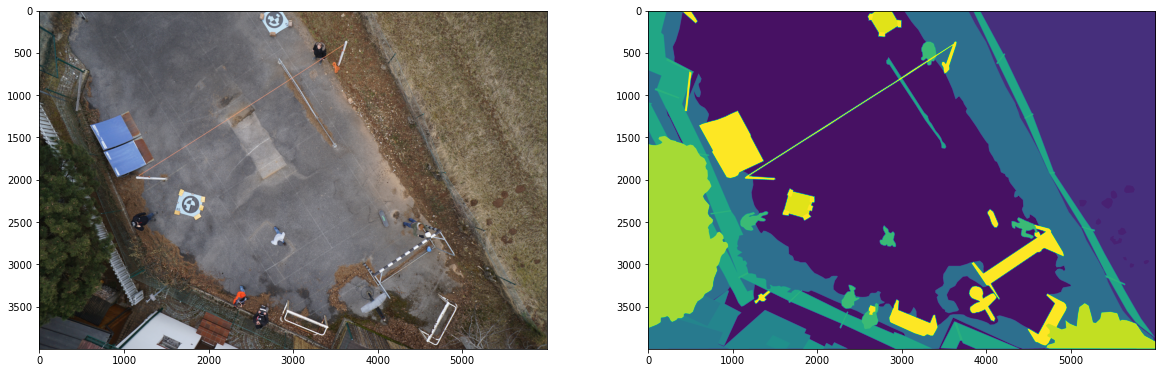

In [6]:
path = '/content/dataset/semantic_drone_dataset/'
img = cv2.imread(path + 'original_images/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path + 'label_images_semantic/001.png', cv2.IMREAD_GRAYSCALE)
#mask = mask.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(mask)

In [7]:
print('Image Dimensions are: ', img.shape)
print('Label Dimensions are: ', mask.shape)

Image Dimensions are:  (4000, 6000, 3)
Label Dimensions are:  (4000, 6000)


**DATA Preprocessing**

Let's Prepare our dataset for the training

In [8]:
# Prepare the Images
X = []
for filename in sorted(os.listdir(path + 'original_images/')):
    a = cv2.imread(path + 'original_images/' + filename)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = cv2.resize(a, (256, 256))
    a = a / 255
    X.append(a)
    
X = np.array(X)

# Prepare the Labels
Y = []
for filename in sorted(os.listdir(path + 'label_images_semantic/')):
    a = cv2.imread(path + 'label_images_semantic/' + filename, cv2.IMREAD_GRAYSCALE)
    a = cv2.resize(a, (256, 256))
    Y.append(a)
    
Y = np.array(Y)
Yc = to_categorical(Y)

(400, 256, 256, 3)
(400, 256, 256, 23)


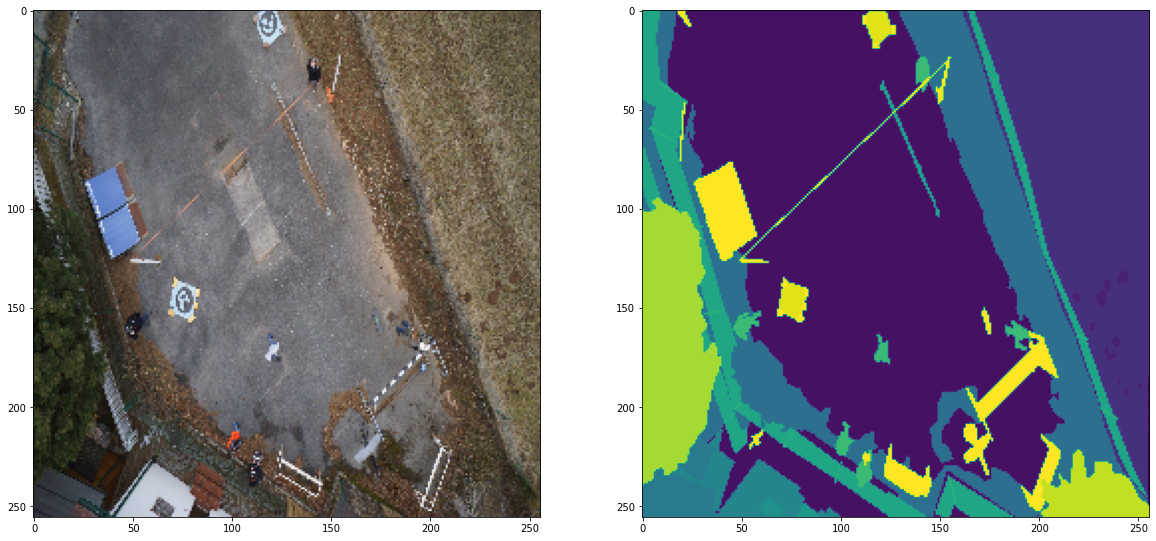

In [9]:
print(X.shape)
print(Yc.shape)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[1])
axs[1].imshow(Y[1])

Now, Let's Split our data into training and validation.

I will keep the last image as a test image to test the Model

In [10]:
test_image1 = X[-1]
test_label1 = Yc[-1]
test_image2 = X[-2]
test_label2 = Yc[-2]
x_train, x_val, y_train, y_val = train_test_split(X[0:-2], Yc[0:-2], test_size = 0.1)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(358, 256, 256, 3)
(358, 256, 256, 23)
(40, 256, 256, 3)
(40, 256, 256, 23)


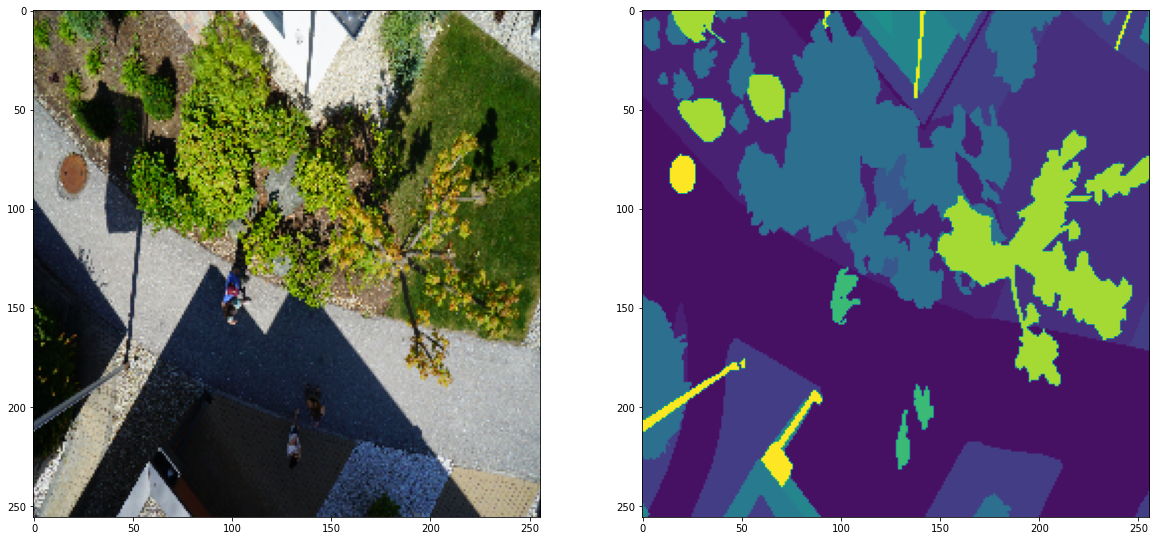

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(x_train[50])
axs[1].imshow(np.argmax(y_train[50], axis=2))

**NOW, We are ready to create the Model, U-NET**

In [13]:
def unet(num_classes = 23, image_shape = (256, 256, 3)):
    # Input
    inputs = Input(image_shape)
    # Encoder Path
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2,2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder Path
    up6 = Conv2D(512, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([up6, conv4], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([up7, conv3], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([up8, conv2], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([up9, conv1], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    
    conv10 = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(conv9)
    
    model = Model(inputs, conv10)
    
    return model

In [14]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

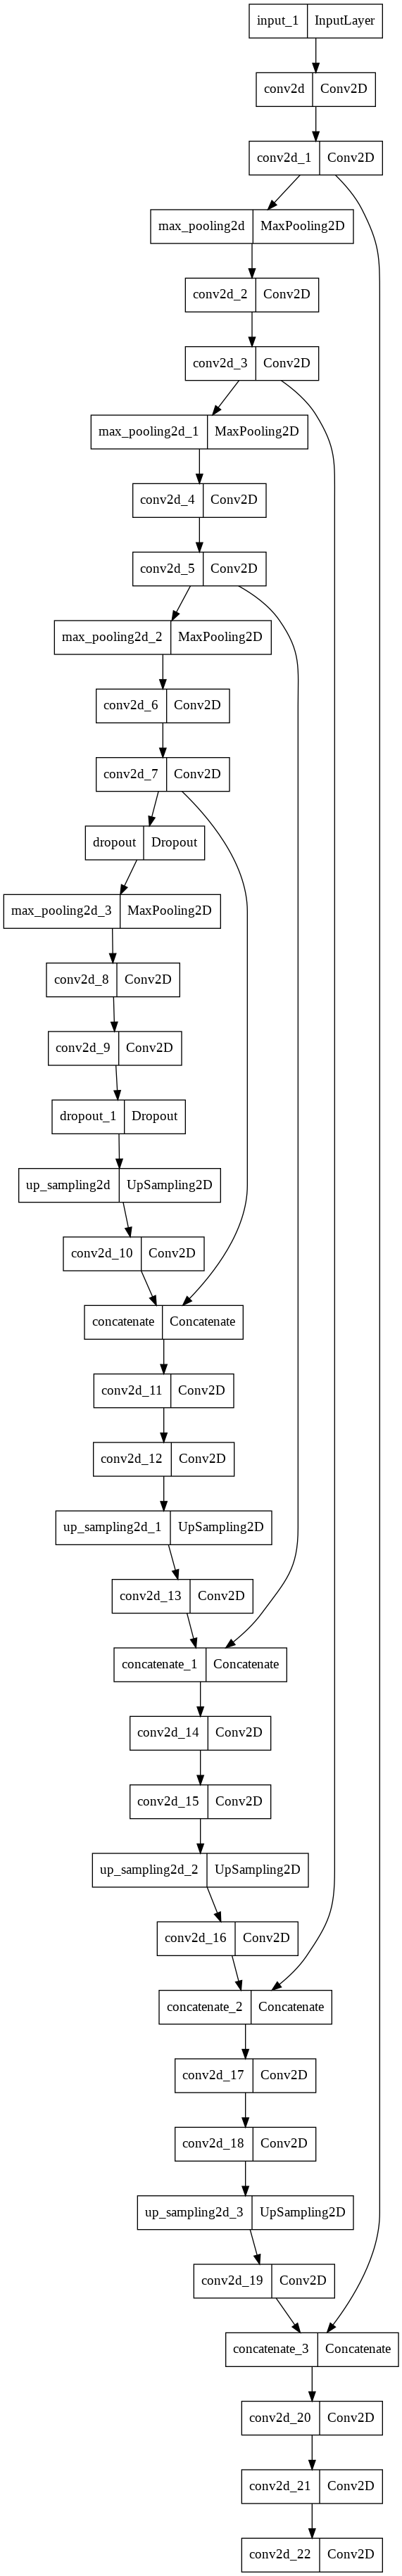

In [15]:
plot_model(model)

Reaching that point successfully, we are now ready to complie and train our model

Although accuracy is not the better metric while doing semantic segmentation, we will just go through this notebook.

In [16]:
model_checkpoint = ModelCheckpoint('unet_model.h5', monitor='val_loss', save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=30)
NUM_EPOCHS = 60
model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=16, epochs=50,
              callbacks=[model_checkpoint, model_earlyStopping])

Epoch 1/50
23/23 [==============================] - 98s 3s/step - loss: 5.7865 - accuracy: 0.3511 - val_loss: 2.1539 - val_accuracy: 0.3688
Epoch 2/50
23/23 [==============================] - 55s 2s/step - loss: 2.0362 - accuracy: 0.4369 - val_loss: 1.8371 - val_accuracy: 0.4686
Epoch 3/50
23/23 [==============================] - 55s 2s/step - loss: 1.8142 - accuracy: 0.5025 - val_loss: 1.6836 - val_accuracy: 0.4906
Epoch 4/50
23/23 [==============================] - 55s 2s/step - loss: 1.7410 - accuracy: 0.5118 - val_loss: 1.6354 - val_accuracy: 0.5324
Epoch 5/50
23/23 [==============================] - 55s 2s/step - loss: 1.6195 - accuracy: 0.5328 - val_loss: 1.5177 - val_accuracy: 0.5687
Epoch 6/50
23/23 [==============================] - 55s 2s/step - loss: 1.5408 - accuracy: 0.5607 - val_loss: 1.4490 - val_accuracy: 0.5759
Epoch 7/50
23/23 [==============================] - 55s 2s/step - loss: 1.4410 - accuracy: 0.5837 - val_loss: 1.3708 - val_accuracy: 0.6102
Epoch 8/50
23/23 [==

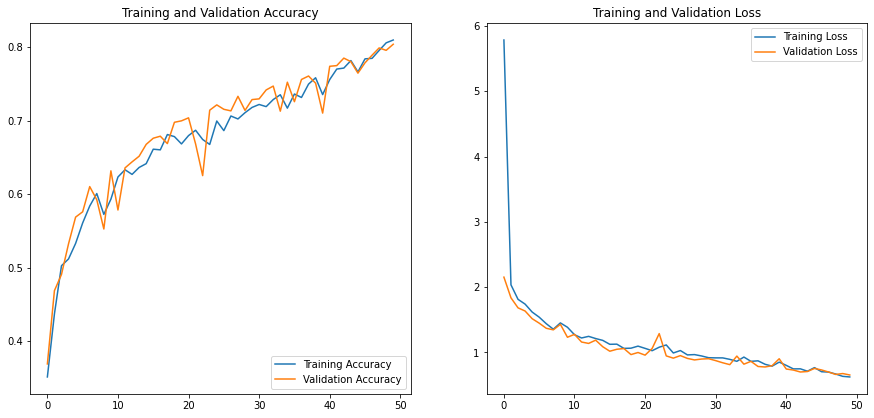

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now, Let's evaluate our Model. I will use the test Image that the model had never seen before.

In [20]:
m1 = test_image1
pred = model.predict(np.expand_dims(m1, 0))
pred_mask = np.argmax(pred, axis=-1)
print(pred_mask.shape)
pred_mask = pred_mask[0]
print(pred_mask.shape)

m2 = test_image2
pred2 = model.predict(np.expand_dims(m2, 0))
pred_mask2 = np.argmax(pred2, axis=-1)
print(pred_mask2.shape)
pred_mask2 = pred_mask2[0]
print(pred_mask2.shape)

(1, 256, 256)
(256, 256)
(1, 256, 256)
(256, 256)


Text(0.5, 1.0, 'Prediction')

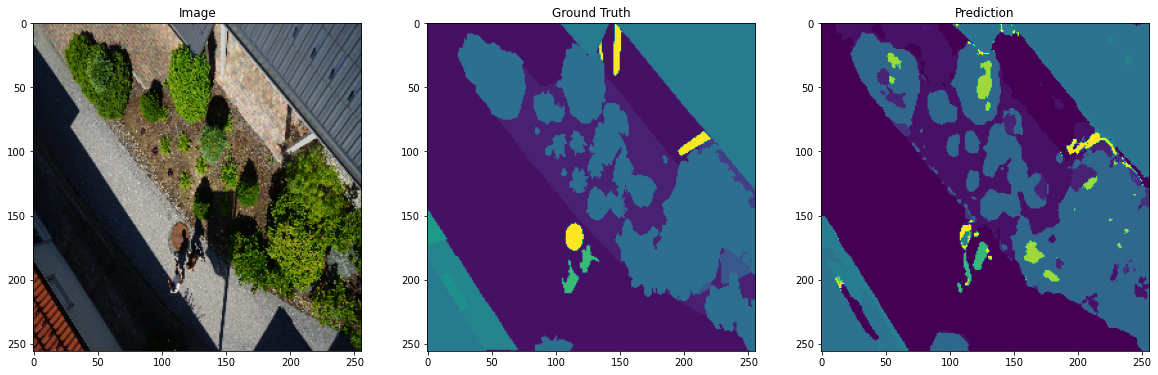

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(np.argmax(test_label1, axis=-1))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask)
axs[2].set_title('Prediction')

Text(0.5, 1.0, 'Prediction')

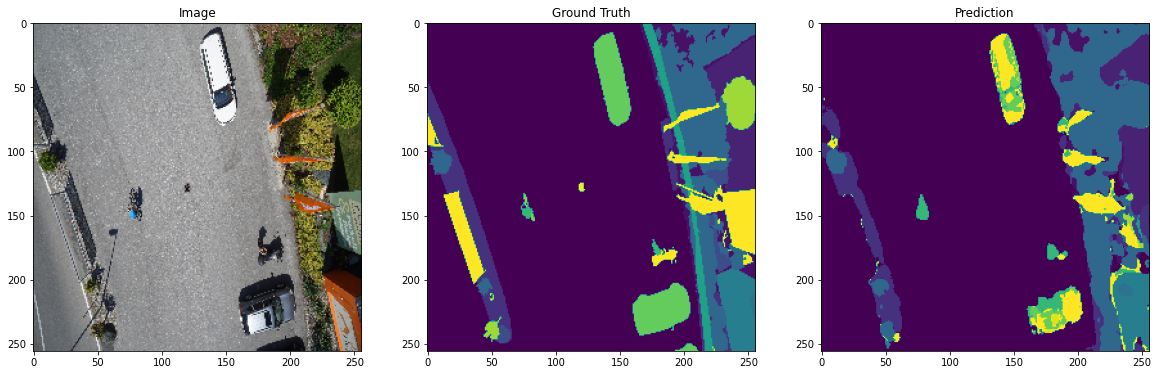

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m2)
axs[0].set_title('Image')
axs[1].imshow(np.argmax(test_label2, axis=-1))
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask2)
axs[2].set_title('Prediction')

In [26]:
from google.colab import files
files.download('unet_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>